# Quick Start Notebook

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

import torch
import torch.nn as nn

from tqdm.auto import tqdm as pbar

dtype = torch.float

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Hyperparameters

In [ ]:
# Constants
SECONDS = 1
MS = 1e-3
HZ = 1

DT = 1 * MS            # large time step to make simulations run faster
ANF_PER_EAR = 100    # repeats of each ear with independent noise

DURATION = .1 * SECONDS # stimulus duration
DURATION_STEPS = int(np.round(DURATION / DT))
INPUT_SIZE = 2 * ANF_PER_EAR

# Training
LR = 0.005
N_EPOCHS = 150
batch_size = 64
n_training_batches = 64
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# classes at 15 degree increments
NUM_CLASSES = 180 // 15
print(f'Number of classes = {NUM_CLASSES}')

# Network
NUM_HIDDEN = 30 # number of hidden units
TAU = 5 # membrane time constant
IE_RATIO = 0.5 # ratio of inhibitory:excitatory units (used if DALES_LAW = True). 0 = all excitatory, 1 = all inhibitory
DALES_LAW = False # When True, units will be only excitatory or inhibitory. When False, units will use both (like a normal ANN)
if DALES_LAW:
    print('Using Dales Law')

Number of classes = 12


## Functions

### Stimulus

input_signal will be called in every iteration to resample for the random offset. The Poisson spikes are only generated once.

In [ ]:
def input_signal(ipd, poisson):
    """
    Generate an input signal (spike array) from array of true IPDs
    """
    envelope_power = 2   # higher values make sharper envelopes, easier
    rate_max = 600 * HZ   # maximum Poisson firing rate
    stimulus_frequency = 20 * HZ

    num_samples = len(ipd)
    times = np.arange(DURATION_STEPS) * DT # array of times
    phi = 2*np.pi*(stimulus_frequency * times + np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, DURATION_STEPS, 2*ANF_PER_EAR))
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi/2, ANF_PER_EAR)
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :ANF_PER_EAR] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, ANF_PER_EAR:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    if poisson is None:
      poisson = np.random.rand(num_samples, DURATION_STEPS, 2*ANF_PER_EAR)
    spikes = poisson<rate_max*DT*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

def random_ipd_input_signal(num_samples, tensor=True):
    """
    Generate the training data
    Returns true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
    """
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    poisson = np.random.rand(num_samples, DURATION_STEPS, 2*ANF_PER_EAR)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)

    return ipd, poisson

def spikes_from_fixed_idp_input_signal(ipd, poisson=None, tensor=True):
    spikes = input_signal(ipd, poisson)
    if tensor:
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return spikes

def show_examples(shown=8):
    ipd = np.linspace(-np.pi/2, np.pi/2, shown)
    spikes = spikes_from_fixed_idp_input_signal(ipd, shown).cpu()

    plt.figure(figsize=(10, 4), dpi=100)
    for i in range(shown):
        plt.subplot(2, shown // 2, i+1)
        plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
        if i>=4:
            plt.xlabel('Time (steps)')
        if i%4==0:
            plt.ylabel('Input neuron index')
    plt.tight_layout()

def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local

def discretise(ipds):
    return ((ipds+np.pi/2) * NUM_CLASSES / np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5) / NUM_CLASSES * np.pi - np.pi / 2

### SNN

In [ ]:
def sigmoid(x, beta):
    return 1 / (1 + torch.exp(-beta*x))

def sigmoid_deriv(x, beta):
    s = sigmoid(x, beta)
    return beta * s * (1 - s)

class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp):
        ctx.save_for_backward(inp)
        out = torch.zeros_like(inp)
        out[inp > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        inp, = ctx.saved_tensors
        sigmoid_derivative = sigmoid_deriv(inp, beta=5)
        grad = grad_output*sigmoid_derivative
        return grad

spike_fn  = SurrGradSpike.apply

def membrane_only(input_spikes, weights, tau):
    """
    :param input_spikes: has shape (batch_size, duration_steps, input_size)
    :param weights: has shape  (input_size, num_classes
    :param tau:
    :return:
    """
    batch_size = input_spikes.shape[0]
    assert len(input_spikes.shape) == 3

    v = torch.zeros((batch_size, NUM_CLASSES), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (input_spikes, weights))
    alpha = np.exp(-DT / tau)
    for t in range(DURATION_STEPS - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)  # (batch_size, duration_steps, num_classes)
    return v_rec

def layer1(input_spikes, w1, tau, sign1):

    if DALES_LAW:
        w1 = get_signed_weights(w1, sign1)

    batch_size = input_spikes.shape[0]

    # First layer: input to hidden
    v = torch.zeros((batch_size, NUM_HIDDEN), device=device, dtype=dtype)
    s = torch.zeros((batch_size, NUM_HIDDEN), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, w1))
    alpha = np.exp(-DT / tau)

    for t in range(DURATION_STEPS - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    return s_rec

def layer2(s_rec, w2, tau, sign2):
    """Second layer: hidden to output"""
    if DALES_LAW:
        w2 = get_signed_weights(w2, sign2)

    v_rec = membrane_only(s_rec, w2, tau=tau)
    return v_rec

def snn(input_spikes, w1, w2, signs, tau=5*MS):
    """Run the simulation"""

    s_rec = layer1(input_spikes, w1, tau, signs[0])
    v_rec = layer2(s_rec, w2, tau, signs[1])

    # Return recorded membrane potential of output
    return v_rec

### Dale's Law

In [ ]:
def get_dales_mask(nb_inputs, nb_out, ie_ratio) :

    d_mask = torch.ones(nb_inputs, nb_out)
    #inhib_units = np.random.choice(nb_inputs, int(nb_inputs*ie_ratio), replace=False)
    inhib_units = torch.arange(ie_ratio*nb_inputs, dtype=int)
    d_mask[inhib_units, :] = -1
    return d_mask

def init_weight_matrices(ie_ratio = 0.1):
    """Weights and uniform weight initialisation"""

    # Input to hidden layer
    w1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w1, -bound, bound)

    # Hidden layer to output
    w2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w2, -bound, bound)

    #Get fixed signs for the weight, 90% excitatory
    signs = [get_dales_mask(*w.shape, ie_ratio).to(w.device) for w in (w1, w2)]

    return w1, w2, signs

def get_signed_weights(w, sign):
    """Get the signed value of the weight"""
    # Note abs is in principle not differentiable.
    # In practice, pytorch will set the derivative to 0 when the values are 0.
    # (see https://discuss.pytorch.org/t/how-does-autograd-deal-with-non-differentiable-opponents-such-as-abs-and-max/34538)
    # This has the adverse effect that, during training, if a synapse reaches 0,
    # it is "culled" and can not be recovered.
    # It should be possible to cheat here and either "wiggle" 0-valued synapses,
    # or to override abs gradient to return a very small random number.

    #TODO try ReLu or other activation
    #TODO reproduce paper https://www.biorxiv.org/content/10.1101/2020.11.02.364968v2.full

   # return torch.max(w, 0)*sign
    return torch.abs(w)*sign

### Training

In [ ]:
def train(w1, w2, signs, ipds, poisson,  ipds_validation, poisson_validation, lr=0.01, n_epochs=30, tau=5*MS):
    """
    :param lr: learning rate
    :return:
    """
    # Optimiser and loss function
    optimizer = torch.optim.Adam([w1, w2], lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    val_loss_hist = []

    best_loss = 1e10
    val_loss_best_loss = 1e10

    for e in pbar(range(n_epochs)):
        local_loss = []
        spikes = spikes_from_fixed_idp_input_signal(ipds, poisson)
        for x_local, y_local in data_generator(discretise(torch.tensor(ipds, device=device, dtype=dtype)), spikes):
            # Run network
            output = snn(x_local, w1, w2, signs, tau=tau)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            reg = 0
            loss = loss_fn(log_softmax_fn(m), y_local) + reg
            local_loss.append(loss.item())

            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))

        val_local_loss = []
        spikes_validation = spikes_from_fixed_idp_input_signal(ipds_validation, poisson_validation)
        for x_local, y_local in data_generator(discretise(torch.tensor(ipds_validation, device=device, dtype=dtype)), spikes_validation):
            # Run network
            output = snn(x_local, w1, w2, signs, tau=tau)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            val_loss = loss_fn(log_softmax_fn(m), y_local)
            val_local_loss.append(val_loss.item())

        val_loss_hist.append(np.mean(val_local_loss))

        if np.mean(val_local_loss) < val_loss_best_loss:
            val_loss_best_loss = np.mean(val_local_loss)
            if DALES_LAW:
                best_weights = get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs
            else:
                best_weights = w1, w2, signs

        #Early Stopping :
        if torch.tensor(val_loss_hist[-10:]).argmin() == 0  and e>10:
            print('Early Stop !')
            return best_weights

    # Plot the loss function over time
    plt.plot(loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    plt.plot(val_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    if DALES_LAW:
        return get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs
    else:
        return w1, w2, signs

### Testing

In [ ]:
def test_accuracy(ipds, poisson, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES))
    spikes = spikes_from_fixed_idp_input_signal(ipds, poisson)
    for x_local, y_local in data_generator((torch.tensor(ipds, device=device, dtype=dtype)), spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.cpu().data.numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)

    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)

    return ipd_true, ipd_est, confusion, accs

def report_accuracy(ipd_true, ipd_est, confusion, accs, label):

    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi

    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true * 180 / np.pi, bins=NUM_CLASSES, label='True')
    plt.hist(ipd_est * 180 / np.pi, bins=NUM_CLASSES, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='equal', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()

def analyse_accuracy(ipds, poisson, run, label):
    ipd_true, ipd_est, confusion, accs = test_accuracy(ipds, poisson, run)
    report_accuracy(ipd_true, ipd_est, confusion, accs, label)
    return 100*np.mean(accs)

## Train Network

Needs lower lr and a few more epochs, but generally it achieves higher accuracy, and it is much more robust to noise.

In [ ]:
# Generate the training data
w1, w2, signs = init_weight_matrices(ie_ratio=IE_RATIO)

ipds_training, poisson_training = random_ipd_input_signal(num_samples, False)
ipds_validation, poisson_validation = random_ipd_input_signal(num_samples, False)

# Train network
w1_trained, w2_trained, signs = train(w1, w2, signs, ipds_training, poisson_training, ipds_validation, poisson_validation, lr=LR, n_epochs=N_EPOCHS, tau=TAU*MS)

  0%|          | 0/150 [00:00<?, ?it/s]

Early Stop !


Chance accuracy level: 8.3%

Train classifier accuracy: 85.0%
Train absolute error: 4.5 deg

Test classifier accuracy: 85.3%
Test absolute error: 4.4 deg


85.302734375

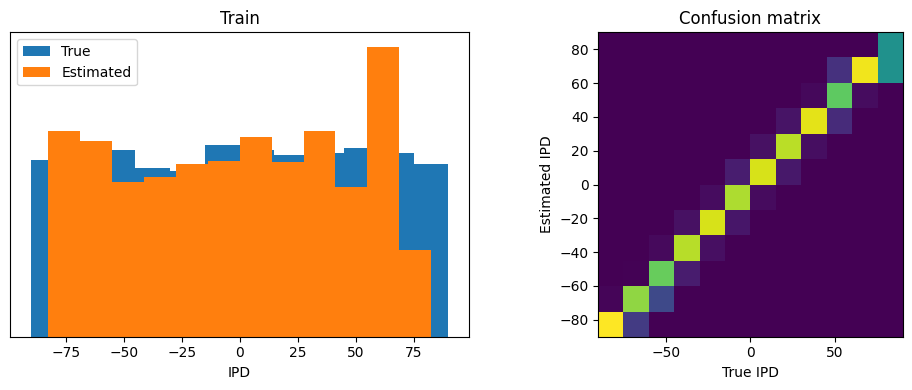

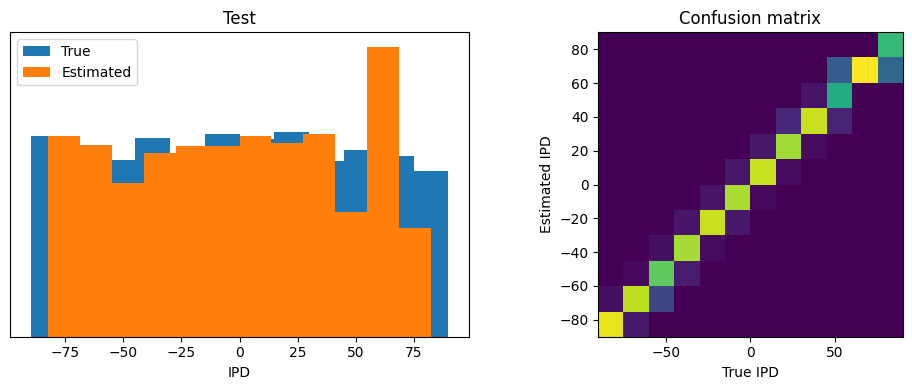

In [ ]:
# Analyse
print(f"Chance accuracy level: {100 * 1 / NUM_CLASSES:.1f}%")
run_func = lambda x: snn(x, w1_trained, w2_trained, signs)
analyse_accuracy(ipds_training, poisson_training, run_func, 'Train')

ipds_test, poisson_test = random_ipd_input_signal(batch_size*n_testing_batches, False)
analyse_accuracy(ipds_test, poisson_test, run_func, 'Test')